In [ ]:
## IEX EDA starts here

In [1]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
print(os.environ.get('IEX_SANDBOX_TOKEN'))
print(os.environ.get('IEX_TOKEN'))

Tsk_2f36139a7da4433bbc4882148386ff32
sk_adc1a33884d64226b0ad7b2e4a5f213e


In [16]:
base_url = 'https://cloud.iexapis.com/v1'
sandbox_url = 'https://sandbox.iexapis.com/stable'

token = os.environ.get('IEX_TOKEN')
sandbox_token = os.environ.get('IEX_SANDBOX_TOKEN')
params = {'token': token}
sandbox_params = {'token': sandbox_token}


In [37]:
# endpoint = '/stock/aapl/chart/36m'
# endpoint = '/stock/aapl/balance-sheet'
# endpoint = '/stock/aapl/financials'
# endpoint = '/time-series/reported_financials/AAPL/10-Q?last=2'
# endpoint = '/time-series'
# endpoint = '/stock/aapl/financials?period=quarter'

# endpoint = '/stock/aapl/price'
endpoint = '/stock/aapl/income/10-Q?last=1'
# resp = requests.get(base_url+endpoint, params = params)
resp = requests.get(sandbox_url+endpoint, params = sandbox_params)

In [25]:
resp.raise_for_status()
income = resp.json()

In [33]:
# df = pd.DataFrame(resp.json())
df

,close,high,low,open,symbol,volume,id,key,subkey,date,...,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent
0,36.4291,38.3980,36.2800,37.7001,AAPL,77847797,_ILOSICTHEPCRRSAI,LPAA,,2017-06-22,...,147.9647,19106554,35.5370,35.9643,35.1325,35.5594,77706168,"Jun 22, 17",0.000000,0.0000
1,38.1800,38.1800,37.7235,37.9102,AAPL,144333002,ACSORPRIHIELCTIS_,AALP,,2017-06-23,...,146.9000,36016766,35.5229,35.1776,35.5580,34.8320,148721808,"Jun 23, 17",0.169320,0.0047
2,37.5660,38.2758,37.5660,38.2758,AAPL,103745046,RLAPTIREI_OSISCCH,LPAA,,2017-06-26,...,148.3000,25801256,36.6212,36.3677,36.7658,34.7913,105882717,"Jun 26, 17",-0.119185,-0.0031
3,36.2965,37.8100,36.2965,36.6339,AAPL,102259704,IOLISTHCIRSEA_CPR,AALP,,2017-06-27,...,147.8600,25366772,35.8933,35.8363,34.8565,34.7272,103726021,"Jun 27, 17",-0.542277,-0.0149
4,38.1741,38.1741,36.5800,37.0997,AAPL,90494140,ITRSIAHCISLPEO_CR,PALA,,2017-06-28,...,144.8866,22269885,34.6496,36.0209,35.0901,34.5802,92637163,"Jun 28, 17",0.537765,0.0147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,135.1200,135.1200,129.9600,129.9600,AAPL,65058825,_RICSRHTSIAICOELP,PALA,,2021-06-15,...,133.7300,64316043,136.1500,130.4300,132.5000,132.5200,64963430,"Jun 15, 21",-0.863989,-0.0065
1001,131.8500,133.6000,131.8500,132.0600,AAPL,94257225,_RRCASPSTOILICEHI,LAAP,,2021-06-16,...,132.0780,96133057,131.2400,133.3300,134.5100,131.0150,94952390,"Jun 16, 21",0.510310,0.0041
1002,134.6000,137.1000,131.0000,131.0000,AAPL,97091492,SRCHOAESICR_IPTIL,AAPL,,2021-06-17,...,131.8000,96903822,135.8000,133.7100,137.3700,132.2300,100656498,"Jun 17, 21",1.683184,0.0127
1003,133.7300,133.7300,133.1400,133.1400,AAPL,111527502,IECLSISI_RTCHRPAO,APAL,,2021-06-18,...,132.4800,113467938,132.0400,132.6100,133.7100,132.7600,108963350,"Jun 18, 21",-1.379449,-0.0105


In [38]:
rev = []
rev_qrt = {}

for num in range(0,len(income['income'])):
    for key in ('fiscalDate','fiscalQuarter','totalRevenue'):
        rev_qrt[key] = income['income'][num].setdefault(key)
    rev.append(rev_qrt)
    rev_qrt = {}



TypeError: list indices must be integers or slices, not str

In [102]:
# rev is a list of dict
# TODO
# add TTM_Revenue
for i in range(len(rev)):
    if (i+3) < len(rev):
        rev[i]['TTM_Revenue'] = rev[i]['totalRevenue'] + rev[i+1]['totalRevenue'] + rev[i+2]['totalRevenue'] + rev[i+3]['totalRevenue']
        
# rev_df = pd.DataFrame(rev)    
# # rename totalRevenue to Quarterly_Revenue
# rev_df = rev_df.rename(columns={'totalRevenue': 'Quarterly_Revenue'})
# rev_df

In [16]:
# If you plan to use this same endpoint a few times, it makes sense to create a function to avoid repeating code. Here is an example:

In [56]:
# param definitions
base_url = 'https://cloud.iexapis.com/v1'
sandbox_url = 'https://sandbox.iexapis.com/stable'

token = os.environ.get('IEX_TOKEN')
sandbox_token = os.environ.get('IEX_SANDBOX_TOKEN')
params = {'token': token}
sandbox_params = {'token': sandbox_token}
    
def revenue_history(_symbol, _params, _last=None):
    # _last defaul is 1; max is 12 (quarters)
    endpoint = f'{sandbox_url}/stock/{_symbol}/income/10-Q'
    if _last:
        endpoint += f'/?last={_last}'
    
    resp = requests.get(endpoint, params=_params)
    resp.raise_for_status()
    resp = resp.json()
    
    rev = []
    rev_qrt = {}
    
    # extract date/quarter/quarterly revenue
    for num in range(0,len(resp['income'])):
        for key in ('fiscalDate','fiscalQuarter','totalRevenue'):
            rev_qrt[key] = resp['income'][num].setdefault(key)
        rev.append(rev_qrt)
        rev_qrt = {}
    
    # add TTM_Revenue
    # the last 3 TTM Revenue would not be available
    for i in range(0,len(rev)):
        if (i+3) < len(rev):
            rev[i]['TTM_Revenue'] = rev[i]['totalRevenue'] + rev[i+1]['totalRevenue'] + rev[i+2]['totalRevenue'] + rev[i+3]['totalRevenue']

    # Calculate quarterly & yearly revenue growth
    q=0
    y=0
    while q < 8:
        rev[q]['Quarterly_Revenue_Growth'] = round((rev[q]['totalRevenue']/rev[q+4]['totalRevenue']-1)*100,2)
        q += 1
    while y < 5:    
        rev[y]['TTM_Revenue_Growth'] = round((rev[y]['TTM_Revenue']/rev[y+4]['TTM_Revenue']-1)*100,2)
        y += 1
    
    # Convert to pandas DF
    rev_df = pd.DataFrame(rev)    
    # rename totalRevenue to Quarterly_Revenue
    rev_df = rev_df.rename(columns={'totalRevenue': 'Quarterly_Revenue'})
    # remove df rows where quarterly_revenue_growth is NaN
    rev_df = rev_df.loc[0:7]
    # use datetime format and sort df by date
    rev_df['fiscalDate'] = pd.to_datetime(rev_df['fiscalDate'], format='%Y/%m/%d')
    rev_df = rev_df.sort_values('fiscalDate')
    
    return rev_df

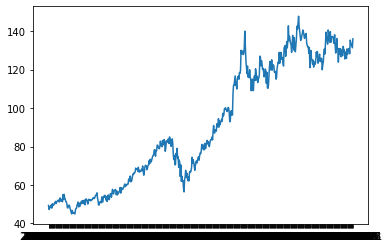

In [69]:
plt.plot(df['date'], df['close'], label = "Daily Close Price")

  fiscalDate  fiscalQuarter  Quarterly_Revenue   TTM_Revenue  \
7 2019-05-16              2         2803248293  1.027770e+10   
6 2019-08-16              3         2861683947  1.083742e+10   
5 2019-11-24              4         3080881642  1.141105e+10   
4 2020-02-14              1         3240118509  1.198593e+10   
3 2020-05-24              2         3269164331  1.245185e+10   
2 2020-08-16              3         3261982954  1.285215e+10   
1 2020-11-24              4         3484503646  1.325577e+10   
0 2021-02-18              1         3987573769  1.400322e+10   

   Quarterly_Revenue_Growth  TTM_Revenue_Growth  
7                     21.78                 NaN  
6                     24.31                 NaN  
5                     22.88                 NaN  
4                     21.57               22.60  
3                     16.62               21.15  
2                     13.99               18.59  
1                     13.10               16.17  
0                     2

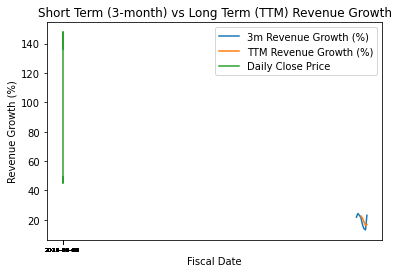

In [68]:
appl_rev_trend = revenue_history('adbe', sandbox_params, 12)
print(appl_rev_trend)
plt.plot(appl_rev_trend['fiscalDate'], appl_rev_trend['Quarterly_Revenue_Growth'], label = "3m Revenue Growth (%)")
plt.plot(appl_rev_trend['fiscalDate'], appl_rev_trend['TTM_Revenue_Growth'], label = "TTM Revenue Growth (%)")
plt.plot(df['date'], df['close'], label = "Daily Close Price")
plt.xlabel('Fiscal Date')
plt.ylabel('Revenue Growth (%)')
plt.title('Short Term (3-month) vs Long Term (TTM) Revenue Growth')
plt.tick_params(axis='x', which='major', labelsize=6)
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [59]:
appl_rev_trend.sort_values('fiscalDate')

,fiscalDate,fiscalQuarter,Quarterly_Revenue,TTM_Revenue,Quarterly_Revenue_Growth,TTM_Revenue_Growth
7,2019-05-18,2,2857616761,1.041831e+10,25.27,NaN
6,2019-08-23,3,2844964117,1.088740e+10,19.74,NaN
5,2019-11-24,4,3023384337,1.138907e+10,19.89,NaN
4,2020-02-17,1,3097004061,1.182297e+10,16.29,20.13
3,2020-05-14,2,3143868758,1.210922e+10,10.02,16.23
2,2020-08-26,3,3367828835,1.263209e+10,18.38,16.02
1,2020-11-14,4,3495634463,1.310434e+10,15.62,15.06
0,2021-02-25,1,3972570687,1.397990e+10,28.27,18.24


In [51]:
# TODO
# calculate monthly average stock price
endpoint = '/stock/aapl/chart/27m'
resp = requests.get(sandbox_url+endpoint, params = sandbox_params)
resp.raise_for_status()
df = pd.DataFrame(resp.json())
df.head()

,close,high,low,open,symbol,volume,id,key,subkey,date,...,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent
0,49.3639,51.0264,49.1240,49.1240,AAPL,177136202,SOTIICRCSHAEIRL_P,LPAA,,2019-03-22,...,193.20,42441602,49.9367,46.8200,48.5664,48.9439,177117397,"Mar 22, 19",0.000000,0.0000
1,47.2560,50.0900,47.2560,48.2307,AAPL,179834032,CTICIAORRSH_LSPIE,LAPA,,2019-03-25,...,187.10,45329309,48.9088,47.8707,47.3639,46.0115,181840777,"Mar 25, 19",-0.591833,-0.0124
2,47.8003,50.1010,47.8003,50.1010,AAPL,205262318,EOARSIISR_PHCTLIC,PLAA,,2019-03-26,...,188.84,51770228,48.6343,47.0166,48.7931,45.3848,208129696,"Mar 26, 19",-0.499152,-0.0104
3,48.8279,49.0900,47.1705,47.8762,AAPL,119819398,SPCLIORR_IAHESTIC,AAPL,,2019-03-27,...,191.97,30546271,47.5084,46.2481,47.6169,47.4531,124157209,"Mar 27, 19",0.432852,0.0090
4,48.6300,49.1124,48.5046,48.5046,AAPL,86950925,OIIPISRCCLSERTHA_,AALP,,2019-03-28,...,189.42,21345463,46.7783,47.4794,46.7450,46.2490,87039289,"Mar 28, 19",0.063900,0.0013


In [63]:
_memory=0

for i in df['date']:
    for j in appl_rev_trend['fiscalDate']:
        if pd.Timestamp(i) == pd.Timestamp(j):
            
        elif pd.Timestamp(i) == pd.Timestamp(j):
            
            print('yes')
        else:
            print('no')
    

In [67]:
df['close'][0:3].mean()

48.14006666666666

In [50]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral3

In [51]:
#make sure MSNDATE is a datetime format
appl_2qrt_df['fiscalDate'] = pd.to_datetime(appl_2qrt_df['fiscalDate'], format='%Y/%m/%d')
p = figure(x_axis_type='datetime')

p.line(x='fiscalDate', y='Quarterly_Revenue_Growth', line_width=2, source=appl_2qrt_df, legend='Quarterly_Revenue_Growth')
p.line(x='fiscalDate', y='TTM_Revenue_Growth', line_width=2, source=appl_2qrt_df, color=Spectral3[2], legend='TTM_Revenue_Growth')

p.yaxis.axis_label = '3-Month vs TTM Revenue'

show(p)

In [17]:
# def historical_data(_symbol, _range=None, _date=None):
#     endpoint = f'{base_url}/stock/{_symbol}/chart'
#     if _range:
#         endpoint += f'/{_range}'
#     elif _date:
#         endpoint += f'/date/{_date}'
    
#     resp = requests.get(endpoint, params=params)
#     resp.raise_for_status()
#     return pd.DataFrame(resp.json())

In [26]:
#appl_3m_df = historical_data('AAPL', _range='1m')